In [ ]:
!pip install pygame==2.0.0.dev4
!python --version
!pip install -U ray 
!pip install ray[rllib]
!pip install ray[tune]
import os
os.environ['SDL_VIDEODRIVER']='dummy'

Python 3.6.9
Requirement already up-to-date: ray in /usr/local/lib/python3.6/dist-packages (0.8.4)


In [ ]:
import gym, ray
from ray.tune.registry import register_env
from ray.rllib.env.multi_agent_env import MultiAgentEnv
import gym
import numpy as np
from gym import spaces
from gym.envs.registration import EnvSpec
import pygame, math, sys, time
from pygame.locals import *
import pygame.camera
import matplotlib.pyplot as plt


from ray.util import named_actors

@ray.remote
class SpeedTracker:
   def __init__(self):
      self.speeds = []
   def update(self, n):
      self.speeds.append(n)
   def reset(self):
      self.speeds = []
   def get(self):
      return self.speeds


class CarSprite(pygame.sprite.Sprite):
    MAX_FORWARD_SPEED = 10
    MAX_REVERSE_SPEED = 0
    ACCELERATION = 2
    TURN_SPEED = 10
    checkpoint=0
    cur_policy = 1
    ready = False

    def __init__(self, image, position):
        pygame.sprite.Sprite.__init__(self)
        self.src_image = pygame.image.load(image)
        self.image = pygame.image.load(image)
        self.position = position
        self.speed = self.direction = 0
        self.k_left = self.k_right = self.k_down = self.k_up = 0
        x, y = (self.position)
        self.rect = self.image.get_rect()
        #self.rect = pygame.Rect(x, y, 30, 30)
        self.rect.center = self.position
        self.steps = 0
        

    
    def update(self, deltat):
        #SIMULATION
        #print(str(self.k_up) + " " + str(self.k_down) + " " +  str(self.k_right) + " " +  str(self.k_left))
        self.speed += (self.k_up + self.k_down)
        if self.speed > self.MAX_FORWARD_SPEED:
            self.speed = self.MAX_FORWARD_SPEED
        if self.speed < -self.MAX_REVERSE_SPEED:
            self.speed = -self.MAX_REVERSE_SPEED
        self.direction += (self.k_right + self.k_left)
        x, y = (self.position)
        rad = self.direction * math.pi / 180
        velocity_x = -self.speed*math.sin(rad)
        velocity_y = -self.speed*math.cos(rad)
        self.steps += 1
        x += velocity_x
        y += velocity_y
        x_c = x
        y_c = y
        self.position = (x, y)

        self.image = pygame.transform.rotate(self.src_image, self.direction)
        self.rect = self.image.get_rect()
        self.rect.center = self.position
        #pygame.draw.rect(screen, (255, 255, 0), self.rect, width=2)



class SensorSprite(pygame.sprite.Sprite):
    xpos = 0
    ypos = 0
    xnew = 0
    ynew = 0
    obj = None

    def __init__(self, x_pos, y_pos, obj):
        self.xpos = x_pos
        self.ypos = y_pos
        self.xnew = obj.rect.centerx + x_pos
        self.ynew = obj.rect.centery + y_pos
        self.obj = obj
        pygame.sprite.Sprite.__init__(self)
        if obj.rect.centerx < self.xnew and y_pos > 0:
            #left, top, width, height
            self.rect = pygame.Rect(obj.rect.centerx, obj.rect.centery, x_pos, y_pos)

        elif obj.rect.centerx > self.xnew and y_pos > 0:
             self.rect = pygame.Rect(self.xnew, obj.rect.centery, abs(x_pos), y_pos)

        elif obj.rect.centerx < self.xnew and y_pos < 0:
            self.rect = pygame.Rect(obj.rect.centerx, self.ynew, x_pos, abs(y_pos))

        else:
            self.rect = pygame.Rect(self.xnew, self.ynew, abs(x_pos), abs(y_pos))
        #self.rect = pygame.draw.line(screen,(255,0,0),(obj.rect.centerx, obj.rect.centery), (self.xnew, obj.rect.centery + y_pos), width=5)
    def update(self):

        rad = -self.obj.direction * math.pi / 180
        s = math.sin(rad);
        c = math.cos(rad);
        x = self.obj.rect.centerx
        y = self.obj.rect.centery

        xnew = c*(self.xpos) - s *(self.ypos) + x
        ynew = s*(self.xpos) + c *(self.ypos) + y

        if x < xnew and y < ynew:
            #left, top, width, height
            self.rect = pygame.Rect(x , y, abs(x - xnew), abs(y - ynew))

        elif x > xnew and y < ynew:
             self.rect = pygame.Rect(xnew , y, abs(x - xnew), abs(y - ynew))

        elif x < xnew and y > ynew:
            self.rect = pygame.Rect(x , ynew, abs(x - xnew), abs(y - ynew))

        else:
            self.rect = pygame.Rect(xnew , ynew, abs(x - xnew), abs(y - ynew))

        #self.rect = pygame.draw.line(screen,(255, 0, 0),(x, y),(xnew, ynew), width=2)




class PadSprite(pygame.sprite.Sprite):
    normal = None
    #hit = pygame.image.load('collision.png')
    def __init__(self, position, image):
        self.image = pygame.image.load(image)
  
        super(PadSprite, self).__init__()
        if image.startswith('pad_vert'):
          self.rect = pygame.Rect(0, 0, 15, 50)
        else:
          self.rect = pygame.Rect(0, 0, 50, 15)
        self.rect.center = position
    def update(self, hit_list):
        if self in hit_list: 
            #self.image = self.hit
            self.position = (50, 50)
        else: self.image = self.normal


class CheckPointSprite(pygame.sprite.Sprite):
    def __init__(self, left, top, width, height, val):
        super(CheckPointSprite, self).__init__()
        self.rect = pygame.Rect(left, top, width, height)
        self.val = val




# environment for all agents in the multiagent world
# currently code assumes that no agents will be created/destroyed at runtime!
class MultiCarEnv2(gym.Env, MultiAgentEnv):
    metadata = {
        'render.modes' : ['human', 'console']
    }

    UP = 0
    DOWN = 1




    def __init__(self):
        super(MultiCarEnv2, self).__init__()

        pygame.init()
        self.screen = pygame.display.set_mode((1024, 800))
        self.screen.fill([128, 128, 128])
        pygame.display.update()


        def drawCirclePad(xc, yc, x, y, pads):
            pads.append(PadSprite((xc + x, yc + y),'pad_sq.png'))
            pads.append(PadSprite((xc - x, yc + y),'pad_sq.png'))
            pads.append(PadSprite((xc + x, yc - y),'pad_sq.png'))
            pads.append(PadSprite((xc - x, yc - y),'pad_sq.png'))
            pads.append(PadSprite((xc + y, yc + x),'pad_sq.png'))
            pads.append(PadSprite((xc - y, yc + x),'pad_sq.png'))
            pads.append(PadSprite((xc + y, yc - x),'pad_sq.png'))
            pads.append(PadSprite((xc - y, yc - x),'pad_sq.png'))


        def circleBres(xc, yc, r, pad):

            x = 0
            y = r; 
            d = 3 - 2 * r 
            drawCirclePad(xc, yc, x, y, pad)
            while y >= x:
                  
                x += 1

                if d > 0:
                    y -= 1
                    d = d + 4 * (x - y) + 10; 
                
                else:
                    d = d + 4 * x + 6; 
                drawCirclePad(xc, yc, x, y, pad)

        pads1 = []
        pads2 = []  

        circleBres(400, 400, 275, pads1)
        circleBres(400, 400, 200, pads2)

        self.pad_group1 = pygame.sprite.RenderPlain(*pads1)
        self.pad_group2 = pygame.sprite.RenderPlain(*pads2)

        car = CarSprite('car.png', (150, 410))
        car2 = CarSprite('car.png', (190, 270))
        car3 = CarSprite('car.png', (275, 185))
        car4 = CarSprite('car.png', (380, 145))
        car5 = CarSprite('car.png', (505, 175))
        car6 = CarSprite('car.png', (620, 280))
        car7 = CarSprite('car.png', (650, 390))
        car8 = CarSprite('car.png', (630, 500))
        car9 = CarSprite('car.png', (525, 615))
        car10 = CarSprite('car.png', (390, 650))
        car11 = CarSprite('car.png', (265, 605))
        car12 = CarSprite('car.png', (175, 520))

        self.cars = [car, car2, car3, car4, car5, car6, car7, car8, car9, car10, car11, car12]

        self.car_group = pygame.sprite.RenderPlain(*self.cars)
        def addSensor(car, sensors):
            sensors.append(SensorSprite(0, -250, car))
            sensors.append(SensorSprite(200, -230, car))
            sensors.append(SensorSprite(-200, -230, car))
            sensors.append(SensorSprite(250, 0, car))
            sensors.append(SensorSprite(-250, 0, car))
            sensors.append(SensorSprite(0, 250, car))
            sensors.append(SensorSprite(200, 230, car))
            sensors.append(SensorSprite(-200, 230, car))

        self.sensors = []

        for c in self.cars:
            curr = []
            addSensor(c, curr)
            self.sensors.append(curr)

        self.sensor_group = []
        for sensor in self.sensors:
          self.sensor_group.append(pygame.sprite.RenderPlain(*sensor))

        self.checkpoints = [CheckPointSprite(25, 350, 150, 150, 1), 
               CheckPointSprite(75, 200, 150, 150, 2),
               CheckPointSprite(175, 75, 150, 150, 3),
               CheckPointSprite(350, 25, 150, 150, 4),
               CheckPointSprite(525, 75, 150, 150, 5), 
               CheckPointSprite(650, 200, 150, 150, 6),
               CheckPointSprite(700, 350, 150, 150, 7),
               CheckPointSprite(350, 25, 150, 150, 8),

               CheckPointSprite(75, 500, 150, 150, 13),
               CheckPointSprite(175, 625, 150, 150, 12),
               CheckPointSprite(350, 700, 150, 150, 11),

               CheckPointSprite(525, 625, 150, 150, 9), 
               CheckPointSprite(650, 500, 150, 150, 10),

               ]
        self.check_group = pygame.sprite.RenderPlain(*self.checkpoints)
    
        self.time = 0

        #accelerate, decelerate, nothing
        self.action_space = spaces.Discrete(3)
        #distance to another object, average velocity of other cars, own velocity
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                        shape=(10,), dtype=np.float32)

        self.wait = 3
        self.step_count = 0

        

    def step(self, action_n):
        self.step_count += 1

        obs_d = {}
        reward_d = {}
        done_d =  {
            "car_0": False,
            #"car_6": False,    
            "__all__": False,  # the env is not done
        }

        info_d = {
            "car_0":{},
            #"car_6":{}  
        }

        obs_n = []
        reward_n = []


        clock = pygame.time.Clock()
        #deltat = clock.tick(30)
        deltat = 30
        self.time += deltat
        # set and perform action for each agent
        i = 0
        idx = [0]
        for key, val in action_n.items():
            cur_action = val
            if cur_action == self.DOWN:
                self.cars[idx[i]].k_down = -0.5
            else:
                self.cars[idx[i]].k_down = 0
            if cur_action == self.UP:
                self.cars[idx[i]].k_up = 0.5
            else: 
                self.cars[idx[i]].k_up = 0
            i += 1

        i = 0
        for car in self.cars:
            

            if self.step_count >= 0 and self.step_count < 35 and i == 5:
                car.speed = 0

            other_cars = self.cars[:]
            other_cars.remove(car)
            other_cars_g = pygame.sprite.Group(other_cars)


            # find the cars in range
            car_near = pygame.sprite.groupcollide(self.sensor_group[i].sprites()[0:3], other_cars_g, False, False, collided = None)
        

            rect_list = []
            car_list = []

            # find the nearest car
            for key, value in car_near.items():
                for val in value:
                    car_list.append(val)
                    newrect = val.rect.clip(key.rect)
                    rect_list.append(newrect)
            # find nearest distance to other car
            mindist = 1000
            minCar = None
            k = 0
            for rec in rect_list:
                dist = math.sqrt((rec.centerx - car.rect.centerx) ** 2 + (rec.centery - car.rect.centery) ** 2)
                if dist < mindist:
                    mindist = dist
                    minCar = car_list[k]
                k += 1

            accel = 0
            
            if i != 0:
                if mindist < 75:
                    accel = -(car.speed/2)
                else:
                    if minCar == None  or car.speed < minCar.speed:
                        accel = 0.2
                car.speed += accel
            else: 
                if mindist < 75:         
                  accel = -(car.speed/2)
                  car.k_down = 0
                  car.k_up = 0
                car.speed += accel
              


            collisions_pad1 = pygame.sprite.spritecollide(car, self.pad_group1, False, collided = None)
            collisions_pad2 = pygame.sprite.spritecollide(car, self.pad_group2, False, collided = None)

            x = car.rect.centerx
            y = car.rect.centery

            theta = (400 - x)/(math.sqrt((x - 400)**2 + (y-400)**2))
            if y > 400:
                #print("here")
                car.direction = (math.degrees(math.acos(theta)) % 360)
            else: 
                car.direction = -math.degrees(math.acos(theta) % 360)

            if len(collisions_pad1) != 0:
                car.direction -= 10
            elif len(collisions_pad2) != 0: 
                car.direction += 10

            i += 1
        
        self.car_group.update(deltat)
        for s in self.sensor_group:
          s.update()

        
        

        avg_speed = 0
        for c in self.cars:
            avg_speed += c.speed
        avg_speed /= len(self.cars)

        # record observation for each agent
        j = 0
        for car in self.cars:
            j += 1
            if j != 1: 
              continue
            current_obs = np.zeros(10)
            current_reward = 0
            closest_obj = 1000

            other_cars = self.cars[:]
            other_cars.remove(car)
            other_car_group = pygame.sprite.Group(other_cars)
            #print(other_cars)

            if car.steps == 1000:
              done_d['__all__'] = True

            for i in range(0, len(self.sensors[j-1])):
                cur_sensor = self.sensors[j-1][i]
                
                #pad_near = pygame.sprite.spritecollide(cur_sensor, self.pad_group1, False, collided = None)
                #pad_near2 = pygame.sprite.spritecollide(cur_sensor, self.pad_group2, False, collided = None)
                car_near = pygame.sprite.spritecollide(cur_sensor, other_car_group, False, collided = None)
                nearest_dist = 400
                rect_list = []
                # use clip rect function
                for other_car in car_near:
                    newrect = other_car.rect.clip(cur_sensor.rect)
                    rect_list.append(newrect)
                for rec in rect_list:
                    cur_dist = math.sqrt((rec.centerx - car.rect.centerx) ** 2 + (rec.centery - car.rect.centery) ** 2)
                    if  cur_dist < nearest_dist:
                        nearest_dist = cur_dist
                current_obs[i] = nearest_dist
                if nearest_dist < closest_obj:
                    closest_obj = nearest_dist
            
            
            current_obs[8] = car.speed
            current_obs[9] = avg_speed

            car_collide = pygame.sprite.spritecollide(car, other_car_group, False, collided = None)
            if len(car_collide) != 0:
                print(car_collide)
                print(car.position)
                for s in self.sensors[2]:
                  print(str(s.xnew) + " " + str(s.ynew))
                print("here " + str(self.step_count) + " " + str(avg_speed))
                done_d['__all__'] = True

            current_reward += avg_speed

            obs_n.append(current_obs)
            reward_n.append(current_reward)
       
        obs_d = {
            "car_0": obs_n[0],
            "car_6": obs_n[1]
        }
        reward_d = {
            "car_0": reward_n[0],
            "car_6": reward_n[1]
        }

        if done_d["__all__"] == True:
            print(avg_speed)
            #speed = named_actors.get_actor("global_counter")
            #speed.update.remote(avg_speed)
            print('Done')


        return obs_d, reward_d, done_d, info_d

    def reset(self):
       
        # record observations for each agent
        obs_n = []

        self.step_count = 0

        

        car = CarSprite('car.png', (150, 410))
        car2 = CarSprite('car.png', (190, 270))
        car3 = CarSprite('car.png', (275, 185))
        car4 = CarSprite('car.png', (380, 145))
        car5 = CarSprite('car.png', (505, 175))
        car6 = CarSprite('car.png', (620, 280))
        car7 = CarSprite('car.png', (650, 390))
        car8 = CarSprite('car.png', (630, 500))
        car9 = CarSprite('car.png', (525, 615))
        car10 = CarSprite('car.png', (390, 650))
        car11 = CarSprite('car.png', (265, 605))
        car12 = CarSprite('car.png', (175, 520))

        self.cars = [car, car2, car3, car4, car5, car6, car7, car8, car9, car10, car11, car12]

        self.car_group = pygame.sprite.RenderPlain(*self.cars)
        def addSensor(car, sensors):
            sensors.append(SensorSprite(0, -250, car))
            sensors.append(SensorSprite(200, -230, car))
            sensors.append(SensorSprite(-200, -230, car))
            sensors.append(SensorSprite(250, 0, car))
            sensors.append(SensorSprite(-250, 0, car))
            sensors.append(SensorSprite(0, 250, car))
            sensors.append(SensorSprite(200, 230, car))
            sensors.append(SensorSprite(-200, 230, car))

        self.sensors = []

        for c in self.cars:
            curr = []
            addSensor(c, curr)
            self.sensors.append(curr)

        self.sensor_group = []
        for sensor in self.sensors:
          self.sensor_group.append(pygame.sprite.RenderPlain(*sensor))
        
        for c in self.cars:
          c.speed = 10

        # record observation for each agent
        j = 0
        for car in self.cars:
            j += 1
            if j != 1:
              continue
            current_obs = np.zeros(10)
            current_reward = 0
            closest_obj = 500

            other_cars = self.cars[:]
            other_cars.remove(car)
            other_car_group = pygame.sprite.Group(other_cars)

            for i in range(0, len(self.sensors[j-1])):
                cur_sensor = self.sensors[j-1][i]
                
                #pad_near = pygame.sprite.spritecollide(cur_sensor, self.pad_group1, False, collided = None)
                #pad_near2 = pygame.sprite.spritecollide(cur_sensor, self.pad_group2, False, collided = None)
                car_near = pygame.sprite.spritecollide(cur_sensor, other_car_group, False, collided = None)
                nearest_dist = 400
                rect_list = []
                # use clip rect function
                for other_car in car_near:
                    newrect = other_car.rect.clip(cur_sensor.rect)
                    rect_list.append(newrect)
                for rec in rect_list:
                    cur_dist = math.sqrt((rec.centerx - car.rect.centerx) ** 2 + (rec.centery - car.rect.centery) ** 2)
                    if  cur_dist < nearest_dist:
                        nearest_dist = cur_dist
                current_obs[i] = nearest_dist
                if nearest_dist < closest_obj:
                    closest_obj = nearest_dist
            
            current_obs[8] = 10
            current_obs[9] = 10

            obs_n.append(current_obs)

        obs_d = {
            "car_0": obs_n[0],
            "car_6": obs_n[1],


        }

        return obs_d


    # render environment
    def render(self, mode='human'):

        self.screen.fill([128, 128, 128])
        self.pad_group.draw(self.screen)
        self.car_group.draw(self.screen)
        pygame.display.update()
        file_num = file_num + 1
        image = cam.get_image()
        # Save every frame
        filename = "Snaps/%04d.png" % file_num
        pygame.image.save(image, filename)
        #pygame.display.flip()



        


pygame 2.0.0.dev4 (SDL 2.0.10, python 3.6.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [ ]:

# environment for all agents in the multiagent world
# currently code assumes that no agents will be created/destroyed at runtime!
class MultiCarEnv3(gym.Env, MultiAgentEnv):
    metadata = {
        'render.modes' : ['human', 'console']
    }

    UP = 0
    DOWN = 1




    def __init__(self):
        super(MultiCarEnv3, self).__init__()

        pygame.init()
        self.screen = pygame.display.set_mode((1024, 800))
        self.screen.fill([128, 128, 128])
        pygame.display.update()


        def drawCirclePad(xc, yc, x, y, pads):
            pads.append(PadSprite((xc + x, yc + y),'pad_sq.png'))
            pads.append(PadSprite((xc - x, yc + y),'pad_sq.png'))
            pads.append(PadSprite((xc + x, yc - y),'pad_sq.png'))
            pads.append(PadSprite((xc - x, yc - y),'pad_sq.png'))
            pads.append(PadSprite((xc + y, yc + x),'pad_sq.png'))
            pads.append(PadSprite((xc - y, yc + x),'pad_sq.png'))
            pads.append(PadSprite((xc + y, yc - x),'pad_sq.png'))
            pads.append(PadSprite((xc - y, yc - x),'pad_sq.png'))


        def circleBres(xc, yc, r, pad):

            x = 0
            y = r; 
            d = 3 - 2 * r 
            drawCirclePad(xc, yc, x, y, pad)
            while y >= x:
                  
                x += 1

                if d > 0:
                    y -= 1
                    d = d + 4 * (x - y) + 10; 
                
                else:
                    d = d + 4 * x + 6; 
                drawCirclePad(xc, yc, x, y, pad)

        pads1 = []
        pads2 = []  

        circleBres(400, 400, 375, pads1)
        circleBres(400, 400, 300, pads2)

        self.pad_group1 = pygame.sprite.RenderPlain(*pads1)
        self.pad_group2 = pygame.sprite.RenderPlain(*pads2)

        car = CarSprite('car.png', (60, 400))
        car2 = CarSprite('car.png', (110, 230))
        car3 = CarSprite('car.png', (215, 115))
        car4 = CarSprite('car.png', (380, 55))
        car5 = CarSprite('car.png', (565, 115))
        car6 = CarSprite('car.png', (690, 240))
        car7 = CarSprite('car.png', (740, 390))
        car8 = CarSprite('car.png', (690, 540))
        car9 = CarSprite('car.png', (565, 665))
        car10 = CarSprite('car.png', (390, 740))
        car11 = CarSprite('car.png', (215, 665))
        car12 = CarSprite('car.png', (115, 540))

        self.cars = [car, car2, car3, car4, car5, car6, car7, car8, car9, car10, car11, car12]

        self.car_group = pygame.sprite.RenderPlain(*self.cars)
        def addSensor(car, sensors):
            sensors.append(SensorSprite(0, -250, car))
            sensors.append(SensorSprite(200, -230, car))
            sensors.append(SensorSprite(-200, -230, car))
            sensors.append(SensorSprite(150, 0, car))
            sensors.append(SensorSprite(-150, 0, car))
            sensors.append(SensorSprite(0, 150, car))
            sensors.append(SensorSprite(100, 130, car))
            sensors.append(SensorSprite(-100, 130, car))

        self.sensors = []

        for c in self.cars:
            curr = []
            addSensor(c, curr)
            self.sensors.append(curr)

        self.sensor_group = []
        for sensor in self.sensors:
          self.sensor_group.append(pygame.sprite.RenderPlain(*sensor))

        self.checkpoints = [CheckPointSprite(25, 350, 150, 150, 1), 
               CheckPointSprite(75, 200, 150, 150, 2),
               CheckPointSprite(175, 75, 150, 150, 3),
               CheckPointSprite(350, 25, 150, 150, 4),
               CheckPointSprite(525, 75, 150, 150, 5), 
               CheckPointSprite(650, 200, 150, 150, 6),
               CheckPointSprite(700, 350, 150, 150, 7),
               CheckPointSprite(350, 25, 150, 150, 8),

               CheckPointSprite(75, 500, 150, 150, 13),
               CheckPointSprite(175, 625, 150, 150, 12),
               CheckPointSprite(350, 700, 150, 150, 11),

               CheckPointSprite(525, 625, 150, 150, 9), 
               CheckPointSprite(650, 500, 150, 150, 10),

               ]
        self.check_group = pygame.sprite.RenderPlain(*self.checkpoints)
    
        self.time = 0

        #accelerate, decelerate, nothing
        self.action_space = spaces.Discrete(3)
        #distance to another object, average velocity of other cars, own velocity
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                        shape=(10,), dtype=np.float32)

        self.wait = 3
        self.step_count = 0

        

    def step(self, action_n):
        self.step_count += 1

        obs_d = {}
        reward_d = {}
        done_d =  {
            "car_0": False,
            "car_1": False,
            "car_2": False,
            "car_3": False,    
            "car_4": False,
            "car_4": False,    
            "car_5": False,
            "car_6": False,    
            "car_7": False,
            "car_8": False,    
            "car_9": False,
            "car_10": False,     
            "car_11": False,    
            "__all__": False,  # the env is not done
        }

        info_d = {
            "car_0":{},
            "car_1":{},  
            "car_2":{},
            "car_3":{}, 
            "car_4":{},
            "car_5":{},  
            "car_6":{},
            "car_7":{},  
            "car_8":{},
            "car_9":{},  
            "car_10":{},
            "car_11":{}   
        }




        obs_n = []
        reward_n = []

        if self.step_count == 1:
          speed = named_actors.get_actor("global_counter")
          speed.reset.remote()


        clock = pygame.time.Clock()
        #deltat = clock.tick(30)
        deltat = 30
        self.time += deltat
        # set and perform action for each agent
        i = 0
        idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
        for key, val in action_n.items():
            cur_action = val
            if cur_action == self.DOWN:
                self.cars[idx[i]].k_down = -1
            else:
                self.cars[idx[i]].k_down = 0
            if cur_action == self.UP:
                self.cars[idx[i]].k_up = 0.5
            else: 
                self.cars[idx[i]].k_up = 0
            i += 1

        i = 0
        for car in self.cars:
            

            if self.step_count >= 20 and self.step_count < 60 and i == 5:
                car.k_up = 0
                car.k_down = 0
                car.speed -= 0.25

            other_cars = self.cars[:]
            other_cars.remove(car)
            other_cars_g = pygame.sprite.Group(other_cars)


            # find the cars in range
            car_near = pygame.sprite.groupcollide(self.sensor_group[i].sprites()[0:3], other_cars_g, False, False, collided = None)
        

            rect_list = []
            car_list = []

            # find the nearest car
            for key, value in car_near.items():
                for val in value:
                    car_list.append(val)
                    newrect = val.rect.clip(key.rect)
                    rect_list.append(newrect)
            # find nearest distance to other car
            mindist = 1000
            minCar = None
            k = 0
            for rec in rect_list:
                dist = math.sqrt((rec.centerx - car.rect.centerx) ** 2 + (rec.centery - car.rect.centery) ** 2)
                if dist < mindist:
                    mindist = dist
                    minCar = car_list[k]
                k += 1

            accel = 0
            
            if i == 20:
                
                if mindist < 75:
                    accel = -(car.speed/2)
                else:
                    if minCar == None  or car.speed < minCar.speed:
                        
                        accel = 0.1
                car.speed += accel
            else: 
                if mindist < 75:         
                  accel = -(car.speed/2)
                  car.k_down = 0
                  car.k_up = 0
                car.speed += accel
              


            collisions_pad1 = pygame.sprite.spritecollide(car, self.pad_group1, False, collided = None)
            collisions_pad2 = pygame.sprite.spritecollide(car, self.pad_group2, False, collided = None)

            x = car.rect.centerx
            y = car.rect.centery

            theta = (400 - x)/(math.sqrt((x - 400)**2 + (y-400)**2))
            if y > 400:
                #print("here")
                car.direction = (math.degrees(math.acos(theta)) % 360)
            else: 
                car.direction = -math.degrees(math.acos(theta) % 360)

            if len(collisions_pad1) != 0:
                car.direction -= 10
            elif len(collisions_pad2) != 0: 
                car.direction += 10

            i += 1
        
        self.car_group.update(deltat)
        for s in self.sensor_group:
          s.update()

        
        

        avg_speed = 0
        for c in self.cars:
            avg_speed += c.speed
        avg_speed /= len(self.cars)
        #print(str(avg_speed) + " " + str(self.cars[0].position))

        # record observation for each agent
        j = 0
        for car in self.cars:
            
            #if j != 1 and j != 7: 
            #  continue
            current_obs = np.zeros(10)
            current_reward = 0
            closest_obj = 1000

            other_cars = self.cars[:]
            other_cars.remove(car)
            other_car_group = pygame.sprite.Group(other_cars)
            #print(other_cars)

            if car.steps == 500:
              done_d['__all__'] = True

            for i in range(0, len(self.sensors[j])):
                cur_sensor = self.sensors[j][i]
                
                pad_near = pygame.sprite.spritecollide(cur_sensor, self.pad_group1, False, collided = None)
                pad_near2 = pygame.sprite.spritecollide(cur_sensor, self.pad_group2, False, collided = None)
                car_near = pygame.sprite.spritecollide(cur_sensor, other_car_group, False, collided = None)
                nearest_dist = 400
                rect_list = []
                # use clip rect function
                for pad in pad_near:
                    newrect = pad.rect.clip(cur_sensor.rect)
                    rect_list.append(newrect)
                for pad in pad_near2:
                    newrect = pad.rect.clip(cur_sensor.rect)
                    rect_list.append(newrect)
                for other_car in car_near:
                    newrect = other_car.rect.clip(cur_sensor.rect)
                    rect_list.append(newrect)
                for rec in rect_list:
                    cur_dist = math.sqrt((rec.centerx - car.rect.centerx) ** 2 + (rec.centery - car.rect.centery) ** 2)
                    if  cur_dist < nearest_dist:
                        nearest_dist = cur_dist
                current_obs[i] = nearest_dist
                if nearest_dist < closest_obj:
                    closest_obj = nearest_dist
            
            
            current_obs[8] = car.speed
            current_obs[9] = avg_speed

            car_collide = pygame.sprite.spritecollide(car, other_car_group, False, collided = None)
            if len(car_collide) != 0:
                print(car_collide)
                print(car.position)
                for s in self.sensors[2]:
                  print(str(s.xnew) + " " + str(s.ynew))
                print("here " + str(self.step_count) + " " + str(avg_speed))
                done_d['__all__'] = True

            current_reward += avg_speed

            obs_n.append(current_obs)
            reward_n.append(current_reward)
            j += 1

        speed = named_actors.get_actor("global_counter")
        speed.update.remote(avg_speed)
       
        obs_d = {
            "car_0": obs_n[0],
            "car_1": obs_n[1],
            "car_2": obs_n[2],
            "car_3": obs_n[3],
            "car_4": obs_n[4],
            "car_5": obs_n[5],
            "car_6": obs_n[6],
            "car_7": obs_n[7],
            "car_8": obs_n[8],
            "car_9": obs_n[9],
            "car_10": obs_n[10],
            "car_11": obs_n[11],
        }
        reward_d = {
            "car_0": reward_n[0],
            "car_1": reward_n[1],
            "car_2": reward_n[2],
            "car_3": reward_n[3],
            "car_4": reward_n[4],
            "car_5": reward_n[5],
            "car_6": reward_n[6],
            "car_7": reward_n[7],
            "car_8": reward_n[8],
            "car_9": reward_n[9],
            "car_10": reward_n[10],
            "car_11": reward_n[11],
        }

        if done_d["__all__"] == True:
            print(avg_speed)
            print("step count: " + str(self.step_count))
            
            print('Done')


        return obs_d, reward_d, done_d, info_d

    def reset(self):
       
        # record observations for each agent
        obs_n = []

        self.step_count = 0

        

        

        car = CarSprite('car.png', (60, 400))
        car2 = CarSprite('car.png', (110, 230))
        car3 = CarSprite('car.png', (215, 115))
        car4 = CarSprite('car.png', (380, 55))
        car5 = CarSprite('car.png', (565, 115))
        car6 = CarSprite('car.png', (690, 240))
        car7 = CarSprite('car.png', (740, 390))
        car8 = CarSprite('car.png', (690, 540))
        car9 = CarSprite('car.png', (565, 665))
        car10 = CarSprite('car.png', (390, 740))
        car11 = CarSprite('car.png', (215, 665))
        car12 = CarSprite('car.png', (115, 540))

        self.cars = [car, car2, car3, car4, car5, car6, car7, car8, car9, car10, car11, car12]

        self.car_group = pygame.sprite.RenderPlain(*self.cars)
        def addSensor(car, sensors):
            sensors.append(SensorSprite(0, -250, car))
            sensors.append(SensorSprite(200, -230, car))
            sensors.append(SensorSprite(-200, -230, car))
            sensors.append(SensorSprite(150, 0, car))
            sensors.append(SensorSprite(-150, 0, car))
            sensors.append(SensorSprite(0, 150, car))
            sensors.append(SensorSprite(100, 130, car))
            sensors.append(SensorSprite(-100, 130, car))

        self.sensors = []

        for c in self.cars:
            curr = []
            addSensor(c, curr)
            self.sensors.append(curr)

        self.sensor_group = []
        for sensor in self.sensors:
          self.sensor_group.append(pygame.sprite.RenderPlain(*sensor))

        for c in self.cars:
          c.speed = 10
         # record observation for each agent
       
        for car in self.cars:
            
            j = 0
            #if j != 1 and j != 7:
            #  continue
            current_obs = np.zeros(10)
            current_reward = 0
            closest_obj = 500

            other_cars = self.cars[:]
            other_cars.remove(car)
            other_car_group = pygame.sprite.Group(other_cars)

            for i in range(0, len(self.sensors[j])):
                cur_sensor = self.sensors[j][i]
                
                pad_near = pygame.sprite.spritecollide(cur_sensor, self.pad_group1, False, collided = None)
                pad_near2 = pygame.sprite.spritecollide(cur_sensor, self.pad_group2, False, collided = None)
                car_near = pygame.sprite.spritecollide(cur_sensor, other_car_group, False, collided = None)
                nearest_dist = 400
                rect_list = []
                # use clip rect function
                for pad in pad_near:
                    newrect = pad.rect.clip(cur_sensor.rect)
                    rect_list.append(newrect)
                for pad in pad_near2:
                    newrect = pad.rect.clip(cur_sensor.rect)
                    rect_list.append(newrect)
                for other_car in car_near:
                    newrect = other_car.rect.clip(cur_sensor.rect)
                    rect_list.append(newrect)
                for rec in rect_list:
                    cur_dist = math.sqrt((rec.centerx - car.rect.centerx) ** 2 + (rec.centery - car.rect.centery) ** 2)
                    if  cur_dist < nearest_dist:
                        nearest_dist = cur_dist
                current_obs[i] = nearest_dist
                if nearest_dist < closest_obj:
                    closest_obj = nearest_dist
            
            current_obs[8] = 10
            current_obs[9] = 10

            obs_n.append(current_obs)
            j += 1

        obs_d = {
            "car_0": obs_n[0],
            "car_1": obs_n[1],
            "car_2": obs_n[2],
            "car_3": obs_n[3],
            "car_4": obs_n[4],
            "car_5": obs_n[5],
            "car_6": obs_n[6],
            "car_7": obs_n[7],
            "car_8": obs_n[8],
            "car_9": obs_n[9],
            "car_10": obs_n[10],
            "car_11": obs_n[11],
        }

        return obs_d


    # render environment
    def render(self, mode='human'):

        self.screen.fill([128, 128, 128])
        self.pad_group.draw(self.screen)
        self.car_group.draw(self.screen)
        pygame.display.update()
        file_num = file_num + 1
        image = cam.get_image()
        # Save every frame
        filename = "Snaps/%04d.png" % file_num
        pygame.image.save(image, filename)
        #pygame.display.flip()



        


2020-04-27 07:14:57,262	INFO resource_spec.py:212 -- Starting Ray with 14.75 GiB memory available for workers and up to 7.39 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-27 07:14:57,671	INFO services.py:1148 -- View the Ray dashboard at localhost:8265
/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-04-27 07:14:59,486	WARNING worker.py:1072 -- The dashboard on node 457fab40eab1 failed with the following error:
Traceback (most recent call last):
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1062, in create_server
    sock.bind(sa)
OSError: [Errno 99] Cannot assign requested address

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ray/dashboard/dashboard.py", l

0.6666717529296875
step count: 500
Done
{'episode_reward_max': 6832.545351087047, 'episode_reward_min': 6832.545351087047, 'episode_reward_mean': 6832.545351087047, 'episode_len_mean': 500.0, 'episodes_this_iter': 1, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [6832.545351087047], 'episode_lengths': [500]}, 'sampler_perf': {'mean_env_wait_ms': 54.855210576466696, 'mean_processing_ms': 1.1585919918890246, 'mean_inference_ms': 7.8213271980514065}, 'off_policy_estimator': {}, 'info': {'exploration_infos': [{'cur_epsilon': 1.0}], 'num_target_updates': 11, 'num_steps_trained': 3328, 'num_steps_sampled': 6000, 'sample_time_ms': 236.088, 'replay_time_ms': 1.576, 'grad_time_ms': 5.921, 'update_time_ms': 0.003, 'opt_peak_throughput': 5404.77, 'opt_samples': 32.0, 'learner': {'default_policy': {'cur_lr': 0.0005000000237487257, 'mean_q': 16.418983, 'min_q': 8.141138, 'max_q': 17.929453, 'mean_td_error': -0.7222

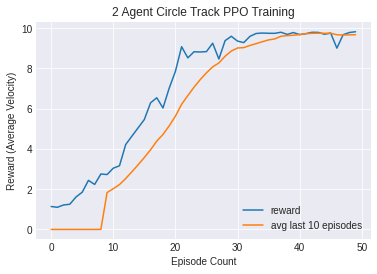

In [ ]:
import random
from ray.rllib.agents.pg.pg import PGTrainer
from ray.rllib.agents.ppo.ppo import PPOTrainer
from ray.rllib.agents.dqn.dqn import DQNTrainer
from ray import tune

ray.init()

num_episodes = 0
cur_reward = 0
final_rewards = []
final_checkpoints =[]




register_env("multienv", lambda config: MultiCarEnv3())

trainer = DQNTrainer(env="multienv", config={"timesteps_per_iteration": 6000, "gamma":.99, "exploration_config": {
        # The Exploration class to use
        "type": "EpsilonGreedy",
        # Config for the Exploration class' constructor:
        "initial_epsilon": 1.0,
        "final_epsilon": 0.05,
        "epsilon_timesteps": 200000,  # Timesteps over which to anneal epsilon.
    },})


final_velocity = []
speed = SpeedTracker.remote()
named_actors.register_actor("global_counter", speed)

i = 0
while i < 50:
    t_dict = trainer.train()
    print(t_dict)
    rewards = t_dict['hist_stats']['episode_reward']
    ep_lens = t_dict['hist_stats']['episode_lengths']
    ep_total = t_dict['episodes_this_iter']
    for j in range(ep_total):
      num_episodes += 1
    for j in range(ep_total):
      final_rewards.append(rewards[j] / 6000)

    # on the driver
    if rewards[0] > 55000:
      final_velocity.append(ray.get(speed.get.remote()))  # get the latest count
    print(len(ray.get(speed.get.remote())))



    i += 1



moving_average = []
curr_total = 0
for i in range(len(final_rewards)):
  if i < 9:
    moving_average.append(0)
    curr_total += final_rewards[i]
  else:
    curr_total += final_rewards[i]
    moving_average.append(curr_total/10)
    curr_total -= final_rewards[i-9]


print(len(final_rewards))
print(num_episodes)
plt.style.use('seaborn-darkgrid')
plt.plot(final_rewards, label="reward")
plt.plot(moving_average, label="avg last 10 episodes")
plt.legend(loc='lower right')
plt.xlabel('Episode Count')
plt.ylabel('Reward (Average Velocity)')
plt.title('2 Agent Circle Track PPO Training')
plt.show()

  
  







50
50


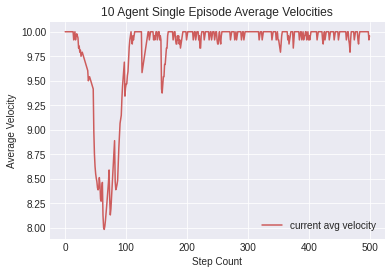

9.59388001505534


In [ ]:
print(len(final_rewards))
print(num_episodes)
plt.style.use('seaborn-darkgrid')
plt.plot(final_velocity[10], label="current avg velocity", color="indianred")
plt.legend(loc='lower right')
plt.xlabel('Step Count')
plt.ylabel('Average Velocity')
plt.title('10 Agent Single Episode Average Velocities')
plt.show()

print(np.mean(final_velocity[5]))